# The Quantum Approximate Optimization Algorithm


In this notebook we are going to see a simple application of the QAOA to a MAXCUT problem on a quantum computer of 5 qubits using Qiskit.

## The MAXCUT problem

We are going to apply the algorithm to a MAXCUT problem, but what does it mean? Suppose to have a graph $G= (V,E)$ and you want to color the vertices of this graph using two colors  in such a way that the maximum possible number of edges has its two vertices of different colors.

We can formally define the problem as an optimization problem where the function to optimize is 

$$
C(\vec{x}) = \sum_{(j,k) \in E} x_{j}(1-x_{k})
$$

where $\vec{x} \in \{ 0,1\}^{|V|}$ is a bit string with its length equal to the number of vertices of the graph. To further complicate the problem, you can consider a weighted MAXCUT problem, by including a matrix of weights $w_{j,k}$ in the cost function. In our case we will continue with the standard MAXCUT problem. 

This problem is known to be a NP-hard problem, that means that no polynomial-time algorithm for MAXCUT in general graphs is known. So in a polynomial time our hope will be restricted to an approximate solution.

#### Relationship with physics?

In statistical physics and disordered systems, the MAXCUT problem is equivalent to minimizing the Hamiltonian of a spin glass model, most simply the Ising model. For the Ising model on a graph G and only nearest-neighbor interactions, the Hamiltonian is

$$
H(s) = - \sum_{(j,k) \in E} J_{j,k} s_j s_k
$$

where each vertex $j$ of the graph is a spin site that can take a spin value $s_j = \pm 1$

In [1]:
import numpy as np
import matplotlib.pyplot as plt 


# We import the tools to handle general Graphs
import networkx as nx

The MAXCUT problem on which we will focus is the following:

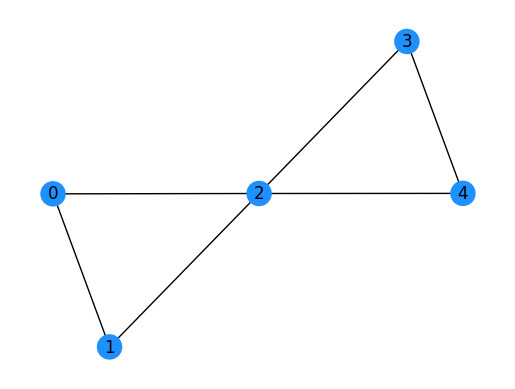

In [2]:
# Generating the butterfly graph with 5 nodes 
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph

colors       = ['dodgerblue' for node in G.nodes()]
default_axes = plt.axes(frameon=False)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=300, alpha=1, ax=default_axes, pos=pos)

## Map the problem to a quantum computer

As we saw thorughout the course, one of the first steps in quantum computing is to map the problem we want to solve into something a quantum device is able to handle. In this case the mapping is very simple: we can map the cost function into a Pauli Hamiltonian of the form 

$$
H = \sum_{(j,k)} \frac{1}{2} ( 1-Z_{j}Z_{k}) 
$$

where $Z_{j}Z_{k}$ is an operator that acts as an identity on all the qubits different from $j,k$ and as a Pauli-$Z$ on them. With this Hamiltonian, the two 'colors' of our qubits will be the two states $|0 \rangle $ and $|1\rangle$. At the end of the algorithm we are going to measure the qubits in the $Z$- basis, the bit string produced as a results will represent the solution suggested by the algorithm.

In [5]:
# importing Qiskit
from qiskit_aer import Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

We want to use our quantum computer to produce a state that measured returns a good approximation of the solution of the MAXCUT problem. In order to do this, we make an ansatz on the structure of the circuit: 

$$ |\psi_p(\vec{\gamma},\vec{\beta})\rangle = e^{ -i\beta_p B } e^{ -i\gamma_p H } \ldots e^{ -i\beta_1 B } e^{ -i\gamma_1 H } |+\rangle_{|V|} $$

where $H$ is the Hamiltonian indicated abve and $B= \sum_{j \in V} X_j $, while the vectors of angles $\vec{\gamma},\vec{\beta}$ have to be optimized in order to maximize the expectation value 

$$
F_p(\vec{\gamma},\vec{\beta}) = \langle \psi_p(\vec{\gamma},\vec{\beta})|H|\psi_p(\vec{\gamma},\vec{\beta})\rangle 
$$

Note that the ansatz is not fixed, the higher value of $p$ we consider, the deeper will be the ansatz. In the following, we are going to consider $p=1$. With this choice of $p$, we have a circuit that first prepare all the qubits in the $ |+\rangle$ state by acting with an Hadamard gate on each of them, then applies a parametrized rotation that depends on the Hamiltonian and then a parameterized rotation on $B$.

We note that, since the Hamiltonian is composed of a sum of operators that commutes with each others, the operator $ e^{ -i\gamma H}$ can be decomposed exactly into a product of rotations depending on the $ZZ$ operator, which can be easily implemented on a quantum computer. The same can be said also for rotation depending on $B$, so the final form of the ansatz will be

$$
|\psi_1(\gamma,\beta)\rangle = \prod_{(j,k) \in E} e^{-\frac{i}{2}\gamma (1- Z_j Z_k)} \prod_{l \in V} e^{ -i\beta X_l }  |+\rangle_{|V|}
$$

In [6]:
def QAOA_circuit(γ,β,G):  
    
    # Returns an appropriate quantum circuit mapping p blocks (length of γ,β) 
    #of evolution according to the cost Hamiltonian induced by graph G
    
    # Create the |+> state on every qubit 
    QAOA=QuantumCircuit(len(G.nodes()),len(G.nodes()))
    QAOA.h(range(len(G.nodes())))
    QAOA.barrier()
    
    for i in range(len(γ)): #exp(-i*γ*H_c) repeated with different angles γ for each block
        for edge in G.edges():
            k = edge[0]
            l = edge[1]
            QAOA.cp(2*γ[i], k, l)
            QAOA.p(-γ[i], k)
            QAOA.p(-γ[i], l)
    
    # then apply the single qubit X - rotations with angle β to all qubits (exp(-i*β*H_b))
        QAOA.barrier()
        QAOA.rx(-2*β[i], range(len(G.nodes())))

    # Finally measure the result in the computational basis
    QAOA.barrier()
    QAOA.measure(range(len(G.nodes())),range(len(G.nodes())))
    
    return QAOA

## Finding the optimal angles 

Now we have mapped the problem and obtained the ansatz circuit. However, this depends on some parameters that has not been set yet. 

In finding the optimal set of angles emerges the hybrid nature of the QAOA: in fact, depending on what type of problem  we are facing, there are different way to choose the best angles for our circuit. As an example, if the ansatz is not too deep, a simple grid search could be used to find them, or we can use some classic optimization algorithms, using  optimizers like ADAM or Adagrad, like they do in [Pennylane](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html). Again, we could use Qiskit already implemented [optimizers](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html) such as COBYLA or the Conjugate Gradient to find the solution, using the quantum computer to iteratively measure the cost function and it's gradient, such as we did in the VQE (this type of ansatz satisfies the conditions for the parameter shift rule to be applied).

In our case, the structure of the graph and of the ansatz is such that we can perform a grid search and find the optimal values of the angles, that are the following:

$$
\beta = 0.2 \quad , \quad \gamma = 1.9
$$

/Users/clemensgiuliani/epfl/teaching/qc24/venv_qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /Users/clemensgiuliani/epfl/teaching/qc24/venv_qiskit/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


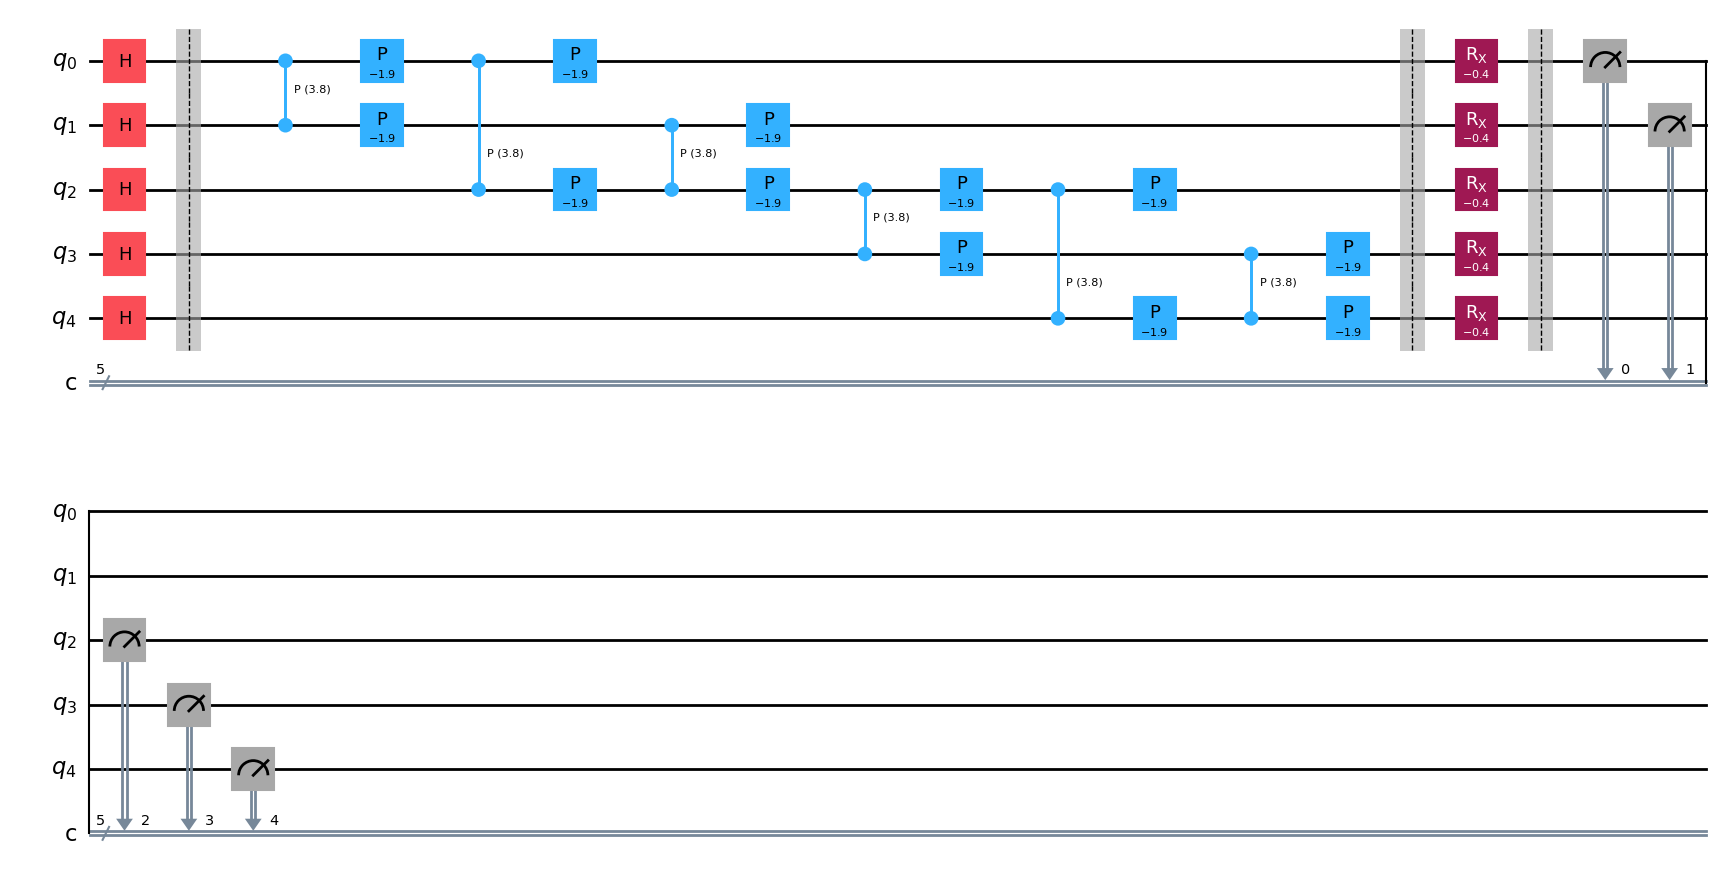

In [7]:
#Create the circuit

QAOA = QAOA_circuit([1.9],[0.2],G)
QAOA.draw('mpl', style={'name': 'iqx'})

## Run the algorithm on simulator

Now that we have all we need to run the algorithm, let's do it on a simulator

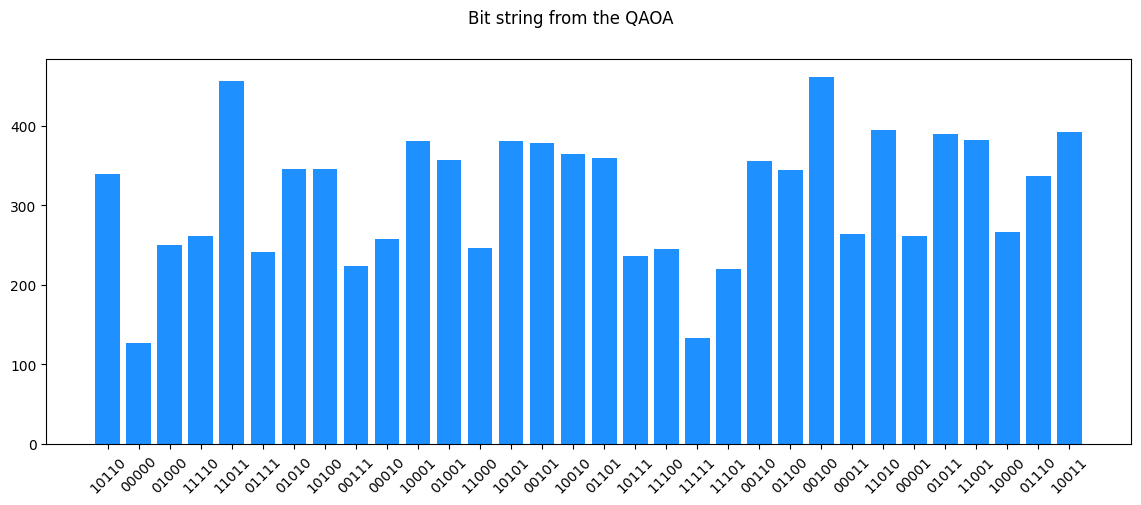

{'10110': 339, '00000': 127, '01000': 250, '11110': 262, '11011': 457, '01111': 242, '01010': 346, '10100': 346, '00111': 224, '00010': 258, '10001': 381, '01001': 357, '11000': 246, '10101': 381, '00101': 378, '10010': 364, '01101': 359, '10111': 236, '11100': 245, '11111': 133, '11101': 220, '00110': 356, '01100': 345, '00100': 461, '00011': 264, '11010': 395, '00001': 261, '01011': 390, '11001': 382, '10000': 266, '01110': 337, '10011': 392}


In [9]:
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

QAOA_results = backend.run(QAOA, shots=shots).result()

answer = QAOA_results.get_counts()

f, ax = plt.subplots(figsize=(14,5))

plt.suptitle("Bit string from the QAOA")
plt.bar(answer.keys(), answer.values(), color='dodgerblue')
plt.xticks(rotation=45)

plt.show()

print(answer)

## Evaluate the solutions

As we can see, there are a lot of possibile answers, since the solution of this problem is not unique. We want now to evaluate how good are the solution found by the algorithm. We need a function that, given a bitstring, evaluate the cost related to the graph we are considering. We can do it by using the classical cost function declared at the beginning of the notebook.

In [10]:
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        C = C + x[e1]*(1-x[e2]) + x[e2]*(1-x[e1])
        
    return C


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.30 

The approximate solution is x* = 10110 with C(x*) = 4 

The cost function is distributed as: 



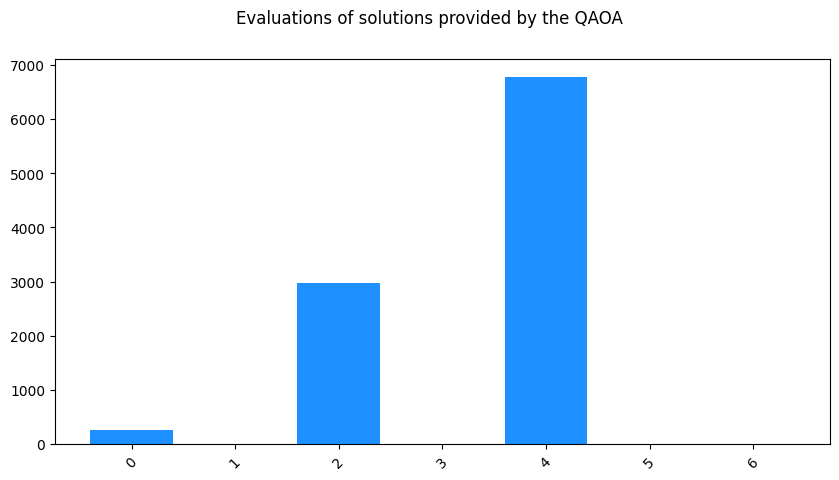

In [11]:
# Now evaluate the solutions

# Solution evaluation and a dictionary to contain the different values of them
avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(answer.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + answer[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + answer[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f \n' % (M1_sampled))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')


f, ax = plt.subplots(figsize=(10,5))

plt.suptitle("Evaluations of solutions provided by the QAOA")
plt.bar(hist.keys(),hist.values(), color='dodgerblue')
plt.xticks(rotation=45)

plt.show()

As you can see, there is an high probability of obtaining a solution that has a cost equal to 4, that we can verify to be the optimal solution. Let's color the graph by using the bitstring we obtained from the algorithm, using `orange` when the bit is `1` and `dodgerblue` when the bit is `0`:

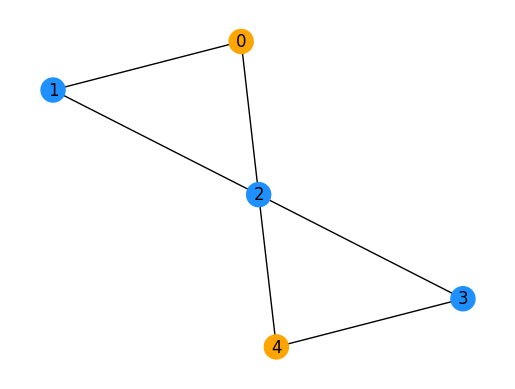

In [12]:
colors       = ['orange','dodgerblue','dodgerblue','dodgerblue','orange']
default_axes = plt.axes(frameon=False)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=300, alpha=1, ax=default_axes, pos=pos)